In [4]:
# setup LLM
import giskard
from llama_index.llms.azure_openai import AzureOpenAI
from giskard.llm import set_llm_model, set_llm_api
from giskard.llm.client import get_default_client
from giskard.llm.client import set_llm_api, set_llm_model
from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
import os

set_llm_api("azure")
set_llm_model('gpt35')

# Azure OpenAI Configuration
llm = AzureOpenAI(
    deployment_name="gpt35",
    temperature=0, 
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-01"
)

Settings.llm = llm

# You'll need to provide the name of the model that you've deployed
# Beware, the model provided must be capable of using function calls
client = get_default_client()
assert client._client._base_url == f'{os.environ["AZURE_OPENAI_ENDPOINT"]}/openai/'
assert client._client.api_key == os.environ["AZURE_OPENAI_API_KEY"]
assert client._client._api_version == os.environ["OPENAI_API_VERSION"]
assert client.model == os.environ["AZURE_OPENAI_CHATGPT_DEPLOYMENT"]


In [2]:
import os
import sys
import logging
import traceback
import pandas as pd
import nest_asyncio
import asyncio
from datetime import datetime
from dotenv import load_dotenv
from typing import List
from huggingface_hub import InferenceApi
from transformers import pipeline
from IPython.display import Markdown, display

nest_asyncio.apply()
load_dotenv()

# LLamaIndex Imports
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.neo4jvector import Neo4jVectorStore
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings, StorageContext, get_response_synthesizer,PropertyGraphIndex, Document, KnowledgeGraphIndex
from llama_index.core.evaluation import (DatasetGenerator,FaithfulnessEvaluator,RelevancyEvaluator)
from llama_index.core.indices.property_graph import SchemaLLMPathExtractor
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.readers.file import PyMuPDFReader
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.graph_stores.neo4j import Neo4jPropertyGraphStore
from llama_index.core.schema import IndexNode, NodeWithScore, Document, QueryBundle
from llama_index.core.extractors import (SummaryExtractor,QuestionsAnsweredExtractor)
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever, VectorIndexRetriever, KGTableRetriever
from llama_index.core.query_engine import RetrieverQueryEngine, KnowledgeGraphQueryEngine, CitationQueryEngine
from llama_index.core.prompts.base import PromptTemplate, PromptType
from llama_index.graph_stores.neo4j import Neo4jGraphStore
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from llama_index.core.retrievers import BaseRetriever


# Giskard imports
import giskard
from giskard.rag import AgentAnswer, evaluate, RAGReport, KnowledgeBase, generate_testset, QATestset
from giskard.rag.metrics.ragas_metrics import ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision
from giskard.llm import set_llm_model, set_llm_api
from giskard.llm.client import get_default_client
from giskard.llm.embeddings import set_default_embedding, get_default_embedding

def remove_openai_api_key():
    if "OPENAI_API_KEY" in os.environ:
        del os.environ["OPENAI_API_KEY"]

# Need to specify this here otherwise it doesn't work - Giskard Problem (?)
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("GSK_AZURE_OPENAI_API_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("GSK_AZURE_OPENAI_ENDPOINT")
os.environ["AZURE_API_VERSION"] = os.getenv("AZURE_API_VERSION")
os.environ["GSK_LLM_API"] = "azure"
os.environ["GSK_LLM_MODEL"] = "gpt-4o-mini"
set_llm_api("azure")
set_llm_model('gpt-4o-mini')

AZURE_API_KEY = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_DEPLOYMENT_NAME = os.getenv("AZURE_DEPLOYMENT_NAME")
AZURE_API_VERSION = os.getenv("AZURE_API_VERSION")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")


embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-large-en-v1.5")
Settings.embed_model = embed_model

# Setup LLM
llm_gpt4o = AzureOpenAI(
    deployment_name="gpt-4o-mini",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

llm_gpt35 = AzureOpenAI(
    deployment_name="gpt35",
    temperature=0, 
    api_key=AZURE_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_API_VERSION
)

# Setup LLM
llm_gpt4o_ = AzureOpenAI(
    deployment_name="gpt4o",
    temperature=0,
    api_key=os.getenv("GPT4O_API_KEY"),
    azure_endpoint=os.getenv("GPT4O_AZURE_ENDPOINT"),
    api_version=os.getenv("GPT4O_API_VERSION")
)

Settings.llm = llm_gpt35

# Verify LLM setup
client = get_default_client()

#print("Client base URL:", client._client._base_url)
#print("Client API key:", client._client.api_key)
#print("Client API version:", client._client._api_version)
#print("Client model:", client.model)

assert client._client._base_url == f'{os.environ["AZURE_OPENAI_ENDPOINT"]}/openai/'
assert client._client.api_key == os.environ["AZURE_OPENAI_API_KEY"]
assert client._client._api_version == os.environ["OPENAI_API_VERSION"]

url = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")
database = os.getenv("NEO4J_DATABASE")

In [2]:
import pandas as pd
import warnings
pd.set_option("display.max_colwidth", 400)
warnings.filterwarnings('ignore')

from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.base.llms.types import ChatMessage, MessageRole
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-large-en-v1.5"
)

loader = PyMuPDFReader()
#file_extractor = {".pdf": loader}
#ipcc_documents1 = loader.load(file_path="../legal_data/LL144/LL144.pdf")
#ipcc_documents2 = loader.load(file_path="../legal_data/LL144/LL144_Definitions.pdf")

ipcc_documents = loader.load(file_path="../../legal_data/EU_AI_ACT/EUAIACT.pdf")  #ipcc_documents1 + ipcc_documents2

splitter = SentenceSplitter(chunk_size=512)
index = VectorStoreIndex.from_documents(ipcc_documents, transformations=[splitter])
chat_engine = index.as_chat_engine(chat_mode="context")

In [3]:
from giskard.rag.question_generators import complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, na_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions

text_nodes = splitter(ipcc_documents)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

In [25]:
from giskard.rag import KnowledgeBase, generate_testset, QATestset
from giskard.rag.question_generators import complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, na_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions
text_nodes = splitter(ipcc_documents)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

testset = generate_testset(knowledge_base,
                           question_generators=[vague_questions],#complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions],
                           num_questions=10,
                           language='en',
                           agent_description="A legal chatbot for the EU AI Act")

testset.to_pandas().head(20)


2024-08-30 13:24:23,265 pid:1217 MainThread giskard.rag  INFO     Finding topics in the knowledge base.
2024-08-30 13:36:38,173 pid:1217 MainThread giskard.rag  INFO     Found 21 topics in the knowledge base.


Generating questions:   0%|          | 0/10 [00:00<?, ?it/s]

,question,reference_answer,reference_context,conversation_history,metadata
id,,,,,
edfb38de-dc65-4d98-9d69-e87e3668a14c,What info is needed?,"The technical documentation shall contain at least a general description of the general-purpose AI model, including the tasks that the model is intended to perform, the type and nature of AI systems in which it can be integrated, the acceptable use policies applicable, the date of release and methods of distribution, the architecture and number of parameters, the modality and format of inputs ...","Document 471: EN\nUnited in diversity\nEN\nANNEX XII\nTransparency information referred to in Article 53(1), point (b)\n- technical documentation for providers of general-purpose AI models to downstream providers \nthat integrate the model into their AI system\nThe information referred to in Article 53(1), point (b) shall contain at least the following:\n1.\nA general description of the genera...",[],"{'question_type': 'vague', 'seed_document_id': 471, 'topic': 'Regulation of AI Models'}"
9b87c73a-2e13-4355-b8d2-b5cee50ddd1d,What’s the purpose of those systems?,"AI systems are intended to be used by a judicial authority to assist in researching and interpreting facts and the law, applying the law to a concrete set of facts, or in alternative dispute resolution. They are also intended to influence the outcome of an election or referendum or the voting behaviour of natural persons.","Document 443: EN\nUnited in diversity\nEN\n8.\nAdministration of justice and democratic processes:\n(a)\nAI systems intended to be used by a judicial authority or on their behalf to assist a \njudicial authority in researching and interpreting facts and the law and in applying \nthe law to a concrete set of facts, or to be used in a similar way in alternative \ndispute resolution;\n(b)\nAI sys...",[],"{'question_type': 'vague', 'seed_document_id': 443, 'topic': 'AI Regulation and Oversight'}"
8cf0b490-a13f-4226-87c5-7ad1fda5d459,When is it a thing?,"A distributor can be considered a provider of a high-risk AI system if they put their name or trademark on a high-risk AI system already placed on the market, or if they make a substantial modification to a high-risk AI system that has already been placed on the market, such that it remains a high-risk AI system.","Document 245: EN\nUnited in diversity\nEN\n5.\nUpon a reasoned request from a relevant competent authority, distributors of a high-risk \nAI system shall provide that authority with all the information and documentation \nregarding their actions pursuant to paragraphs 1 to 4 necessary to demonstrate the \nconformity of that system with the requirements set out in Section 2. ▌\n6.\nDistributors...",[],"{'question_type': 'vague', 'seed_document_id': 245, 'topic': 'High-Risk AI Regulation'}"
acb585a2-41a3-42bf-ac0d-3ce4379c3cca,Who's in charge?,The Commission shall be the controller of the EU database.,"Document 356: EN\nUnited in diversity\nEN\n4.\nWith the exception of the section referred to in Article 49(4) and Article 60(4), point (c), \nthe information contained in the EU database registered in accordance with Article 49 \nshall be accessible and publicly available in a user-friendly manner. The information \nshould be easily navigable and machine-readable. The information registered in...",[],"{'question_type': 'vague', 'seed_document_id': 356, 'topic': 'AI Regulation and Oversight'}"
be59ad95-d744-45a0-859a-24d38874d26c,What can be done about risks?,"The AI Office can implement mitigation measures, restrict the making available on the market, withdraw, or recall the model.","Document 395: EN\nUnited in diversity\nEN\n(b)\nimplement mitigation measures, where the evaluation carried out in accordance \nwith Article 92 has given rise to serious and substantiated concern of a systemic \nrisk at Union level;\n(c)\nrestrict the making available on the market, withdraw or recall the model.\n2.\nBefore a measure is requested, the AI Office may initiate a structur

In [5]:
import giskard
from giskard.rag import KnowledgeBase, generate_testset, QATestset
from giskard.rag.question_generators import complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, na_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions

testset = generate_testset(knowledge_base,
                           question_generators=[vague_questions],#complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions],
                           num_questions=25,
                           language='en',
                           agent_description="A legal chatbot for the EU AI Act")

testset.to_pandas().head(20)

Generating questions:   0%|          | 0/25 [00:00<?, ?it/s]

,question,reference_answer,reference_context,conversation_history,metadata
id,,,,,
03e11423-cd2b-45f8-8abc-a613992f6512,What considerations might countries have when determining penalties for regulatory breaches?,"Member States should take into account all relevant circumstances of the specific situation, with due regard in particular to the nature, gravity and duration of the infringement and of its consequences and to the size of the provider, in particular if the provider is an SME, including a start-up.","Document 163: EN\nUnited in diversity\nEN\n(168)\nCompliance with this Regulation should be enforceable by means of the imposition of \npenalties and other enforcement measures. Member States should take all necessary \nmeasures to ensure that the provisions of this Regulation are implemented, including by \nlaying down effective, proportionate and dissuasive penalties for their infringement, ...",[],"{'question_type': 'vague', 'seed_document_id': 163, 'topic': 'AI Regulation and Compliance'}"
c96bd6b6-4017-40a9-bda1-34bc4d684df0,What needs to be secured from individuals before they engage in practical testing?,Freely-given informed consent shall be obtained from the subjects of testing prior to their participation.,"Document 335: EN\nUnited in diversity\nEN\nArticle 61\nInformed consent to participate in testing in real world conditions\n outside AI regulatory sandboxes\n1.\nFor the purpose of testing in real world conditions under Article 60, freely-given \ninformed consent shall be obtained from the subjects of testing prior to their \nparticipation in such testing and after their having been duly infor...",[],"{'question_type': 'vague', 'seed_document_id': 335, 'topic': 'AI Testing Regulations'}"
6bdf866f-d21e-458f-b356-b3161ec65c2c,How is a certain type of AI model characterized in the given context?,"'General-purpose AI model' means an AI model that displays significant generality and is capable of competently performing a wide range of distinct tasks regardless of the way the model is placed on the market and that can be integrated into a variety of downstream systems or applications, except AI models that are used for research, development or prototyping activities before they are placed...","Document 191: EN\nUnited in diversity\nEN\n(62)\n‘critical infrastructure’ means critical infrastructure as defined in Article 2, point (4), of \nDirective (EU) 2022/2557;\n(63)\n‘general-purpose AI model’ means an AI model, including where such an AI model is \ntrained with a large amount of data using self-supervision at scale, that displays \nsignificant generality and is capable of compete...",[],"{'question_type': 'vague', 'seed_document_id': 191, 'topic': 'General-Purpose AI Models'}"
9df78817-b193-452c-95b4-bf2e5bd62b01,What are the obligations for reporting by certain authorities under a specific article of a recent regulation?,"The market surveillance authorities shall report annually to the Commission and relevant national competition authorities any information identified in the course of market surveillance activities that may be of potential interest for the application of Union law on competition rules, as well as about the use of prohibited practices that occurred during that year and about the measures taken.","Document 363: EN\nUnited in diversity\nEN\n2.\nAs part of their reporting obligations under Article 34(4) of Regulation (EU) 2019/1020, \nthe market surveillance authorities shall report annually to the Commission and relevant \nnational competition authorities any information identified in the course of market \nsurveillance activities that may be of potential interest for the application of ...",[],"{'question_type': 'vague', 'seed_document_id': 363, 'topic': 'AI Regulation and Oversight'}"
0e4a9507-1c56-4b51-afd2-c353ab2a23d5,What should each Member State do a few months after the new Regulation takes effect?,Each Member State shall identify the public authorities or bodies referred to in paragraph 1

In [7]:
Settings.llm = llm_gpt4o

testset = generate_testset(knowledge_base,
                           question_generators=[complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions],
                           num_questions=300,
                           language='en',
                           agent_description="A legal chatbot for the EU AI Act")

testset.to_pandas().head(20)

Generating questions:   0%|          | 0/300 [00:00<?, ?it/s]

,question,reference_answer,reference_context,conversation_history,metadata
id,,,,,
0040d294-9a22-4de2-a96b-46a5197d3c18,"What specific information must national market surveillance authorities and national data protection authorities submit to the Commission, including any annual reporting requirements, regarding the deployment of 'real-time' remote biometric identification systems for law enforcement in publicly accessible spaces?","They must submit annual reports on such use, including information on the number of decisions taken by competent judicial authorities or an independent administrative authority whose decision is binding upon requests for authorisations and their result.","Document 200: EN\nUnited in diversity\nEN\n4.\nWithout prejudice to paragraph 3, each use of a ‘real-time’ remote biometric \nidentification system in publicly accessible spaces for law enforcement purposes shall be \nnotified to the relevant market surveillance authority and the national data protection \nauthority in accordance with the national rules referred to in paragraph 5. The \nnotifi...",[],"{'question_type': 'complex', 'seed_document_id': 200, 'topic': 'Biometric Data and AI'}"
51e5a200-5fc7-44f3-b23e-ac6b9b526ca1,"In the context of employment and workers management, what specific purposes are AI systems designed to fulfill, particularly regarding recruitment, performance evaluation, and decision-making related to employment contracts?","AI systems are intended to be used for recruitment or selection of natural persons, to place targeted job advertisements, to analyse and filter job applications, and to evaluate candidates; as well as to make decisions affecting terms of work-related relationships, the promotion or termination of work-related contractual relationships, to allocate tasks based on individual behaviour or persona...","Document 439: EN\nUnited in diversity\nEN\n4.\nEmployment, workers management and access to self-employment:\n(a)\nAI systems intended to be used for the recruitment or selection of natural persons, in \nparticular to place targeted job advertisements, to analyse and filter job \napplications, and to evaluate candidates;\n(b)\nAI systems intended to be used to make decisions affecting terms of...",[],"{'question_type': 'complex', 'seed_document_id': 439, 'topic': 'AI Regulation and Ethics'}"
67e2c189-c03b-4360-a050-cd85b1af1959,"In the context of the EU AI Act, what specific elements must be detailed in the hardware description of an AI system, including any relevant illustrations or user-interface aspects?",The description of the hardware on which the AI system is intended to run.,"Document 445: EN\nUnited in diversity\nEN\n(e)\nthe description of the hardware on which the AI system is intended to run;\n(f)\nwhere the AI system is a component of products, photographs or illustrations \nshowing external features, the marking and internal layout of those products;\n(g)\na basic description of the user-interface provided to the deployer;\n(h)\ninstructions for use for the d...",[],"{'question_type': 'complex', 'seed_document_id': 445, 'topic': 'AI Regulation and Compliance'}"
5875523e-76bf-4677-ab9a-9bce02013a8f,"In the context of AI regulatory sandboxes, what specific responsibilities do national competent authorities hold, particularly regarding resource allocation and cooperation with other relevant entities?","National competent authorities shall ensure that they allocate sufficient resources to comply with the regulations effectively and in a timely manner, and they should cooperate with other relevant authorities and allow for the involvement of other actors within the AI ecosystem.","Document 314: EN\nUnited in diversity\nEN\n2.\nAdditional AI regulatory sandboxes at regional or local level, or established jointly with \nthe competent authorities of other Member States may also be established.\n3.\nThe European Data Protection Supervisor may also establish an AI regulatory sandbox \nfor Union institutio

In [6]:
testset.save("eu_ai_act_test_vague_only.jsonl")

In [7]:
file_path = "eu_ai_act_test_300_new.jsonl"

In [9]:
import json
from collections import defaultdict

# File path for the JSONL file
file_path = "eu_ai_act_test_300_new.jsonl"
new_file_path = file_path.replace('.jsonl', '_new.jsonl')

# Initialize variables
row_count = 0
question_type_counts = defaultdict(int)
question_counts = defaultdict(int)
duplicate_questions = set()  # Changed to a set to avoid duplicates in the list
unique_data = []  # List to store unique rows

# Open the JSONL file and process it in a single pass
with open(file_path, 'r') as file:
    for line in file:
        row_count += 1  # Increment row count for each line
        
        try:
            # Parse the JSON data in each line
            data = json.loads(line)
            
            # Extract and count question types
            question_type = data['metadata']['question_type']
            question_type_counts[question_type] += 1
            
            # Extract the question field and check for duplicates
            question = data['question']
            question_counts[question] += 1
            
            if question_counts[question] == 2:  # If this question appears more than once, it's a duplicate
                duplicate_questions.add(question)
            elif question_counts[question] == 1:  # Only add unique questions
                unique_data.append(data)
                
        except json.JSONDecodeError:
            print("Error decoding JSON line. Skipping.")
        except KeyError:
            print("KeyError encountered. Skipping.")

# Print the total number of rows and counts for each question type before removal
print(f'The number of rows in the JSONL file before removal is: {row_count}')
print("\nCounts for each question type before removal:")
for question_type, count in question_type_counts.items():
    print(f'Question Type: {question_type}, Count: {count}')

# Print duplicate questions, if any
if duplicate_questions:
    print("\nDuplicate questions found:")
    for question in duplicate_questions:
        print(question)
else:
    print("\nNo duplicate questions found.")

# Remove duplicates and update metrics
row_count_after_removal = len(unique_data)
question_type_counts_after_removal = defaultdict(int)

for data in unique_data:
    question_type = data['metadata']['question_type']
    question_type_counts_after_removal[question_type] += 1

# Print the updated metrics after removing duplicates
print(f'\nThe number of rows in the JSONL file after removal is: {row_count_after_removal}')
print("\nCounts for each question type after removal:")
for question_type, count in question_type_counts_after_removal.items():
    print(f'Question Type: {question_type}, Count: {count}')

# Save the unique rows to a new JSONL file
with open(new_file_path, 'w') as new_file:
    for data in unique_data:
        json.dump(data, new_file)
        new_file.write('\n')

print(f"\nUnique rows have been saved to {new_file_path}")


The number of rows in the JSONL file before removal is: 294

Counts for each question type before removal:
Question Type: complex, Count: 28
Question Type: complex_situational, Count: 28
Question Type: compare, Count: 28
Question Type: simple, Count: 26
Question Type: rule_conclusion, Count: 27
Question Type: distracting element, Count: 27
Question Type: vague, Count: 27
Question Type: out of scope, Count: 27
Question Type: situational, Count: 27
Question Type: double, Count: 26
Question Type: conversational, Count: 23

No duplicate questions found.

The number of rows in the JSONL file after removal is: 294

Counts for each question type after removal:
Question Type: complex, Count: 28
Question Type: complex_situational, Count: 28
Question Type: compare, Count: 28
Question Type: simple, Count: 26
Question Type: rule_conclusion, Count: 27
Question Type: distracting element, Count: 27
Question Type: vague, Count: 27
Question Type: out of scope, Count: 27
Question Type: situational, Coun

The number of rows in the JSONL file is: 294

Counts for each question type:
Question Type: complex, Count: 28
Question Type: complex_situational, Count: 28
Question Type: compare, Count: 28
Question Type: simple, Count: 26
Question Type: rule_conclusion, Count: 27
Question Type: distracting element, Count: 27
Question Type: vague, Count: 27
Question Type: out of scope, Count: 27
Question Type: situational, Count: 27
Question Type: double, Count: 26
Question Type: conversational, Count: 23


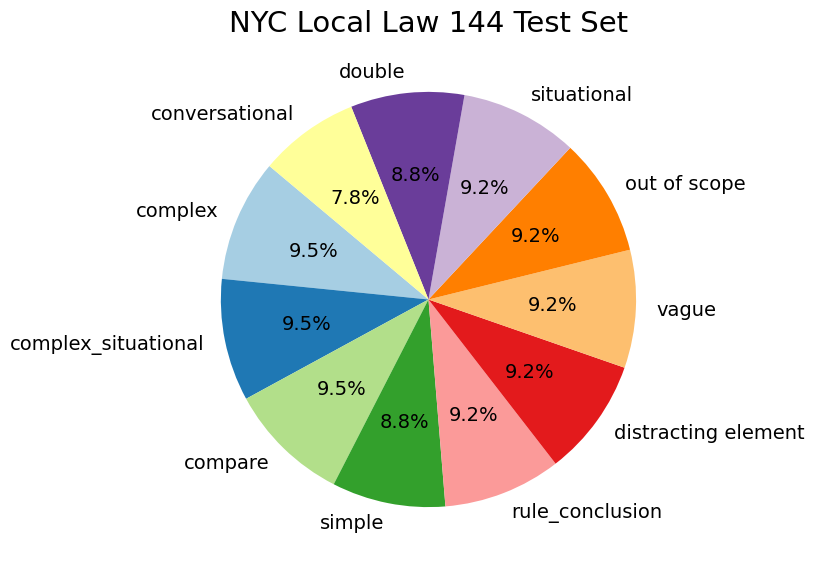

In [10]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

def analyze_and_plot_jsonl(file_path):
    # Initialize variables
    question_type_counts = defaultdict(int)
    total_rows = 0

    # Read and process the JSONL file
    with open(file_path, 'r') as file:
        for line in file:
            total_rows += 1  # Increment row count for each line
            try:
                # Parse the JSON data in each line
                data = json.loads(line)
                
                # Extract and count question types
                question_type = data['metadata']['question_type']
                question_type_counts[question_type] += 1
                
            except json.JSONDecodeError:
                print("Error decoding JSON line. Skipping.")
            except KeyError:
                print("KeyError encountered. Skipping.")
    
    # Print the total number of rows
    print(f'The number of rows in the JSONL file is: {total_rows}')
    
    # Print the counts for each question type
    print("\nCounts for each question type:")
    for question_type, count in question_type_counts.items():
        print(f'Question Type: {question_type}, Count: {count}')

    # Plot a pie chart of the question type distribution
    question_types = list(question_type_counts.keys())
    counts = list(question_type_counts.values())

    plt.figure(figsize=(8, 8))
    plt.pie(
        counts, 
        labels=question_types, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=plt.cm.Paired.colors, 
        textprops={'fontsize': 14}  # Increase font size for labels and percentages
    )
    plt.title('EU AI Act Test Set', fontsize=21)  # Increase font size for title

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
file_path = "eu_ai_act_test_300_new.jsonl"  # Replace with your actual file path
analyze_and_plot_jsonl(file_path)


In [14]:
from giskard.rag import KnowledgeBase, generate_testset, QATestset
from giskard.rag.question_generators import complex_questions, complex_situational_questions, compare_questions, simple_questions, rule_conclusion_questions, distracting_questions, na_questions, vague_questions, oos_questions, situational_questions, double_questions, conversational_questions
text_nodes = splitter(ipcc_documents)
knowledge_base_df = pd.DataFrame([node.text for node in text_nodes], columns=["text"])
knowledge_base = KnowledgeBase(knowledge_base_df)

In [15]:
from giskard.rag import AgentAnswer
from giskard.rag import evaluate, RAGReport
from giskard.rag.metrics.ragas_metrics import ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision


retriever = index.as_retriever(similarity_top_k=5)

def answer_fn(question, history=None):
    if history:
        answer = chat_engine.chat(question, chat_history=[ChatMessage(role=MessageRole.USER if msg["role"] =="user" else MessageRole.ASSISTANT,
                                                          content=msg["content"]) for msg in history])
    else:
        answer = chat_engine.chat(question, chat_history=[])
    return str(answer)


def get_answer_fn(question: str, history=None) -> str:
    """A function representing your RAG agent."""
    # Format appropriately the history for your RAG agent
    messages = history if history else []
    messages.append({"role": "user", "content": question})

    # Get the answer and the documents
    #agent_output = get_answer_from_agent(messages)
    answer = answer_fn(question, history)
    retrieved_nodes = retriever.retrieve(question)
    documents = [node.node.text for node in retrieved_nodes]
    print(documents)

    # Following llama_index syntax, you can get the answer and the retrieved documents
    #answer = agent_output.text
    #documents = agent_output.source_nodes

    # Instead of returning a simple string, we return the AgentAnswer object which
    # allows us to specify the retrieved context which is used by RAGAS metrics
    return AgentAnswer(
        message=answer,
        documents=documents
    )

report = evaluate(get_answer_fn,
                testset=testset,
                knowledge_base=knowledge_base,
                metrics=[ragas_context_recall, ragas_faithfulness, ragas_answer_relevancy, ragas_context_precision])

Asking questions to the agent:   0%|          | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Asking questions to the agent:  20%|██        | 1/5 [00:03<00:13,  3.43s/it]

['d. A proceeding to recover any civil penalty authorized by this subchapter is returnable to any tribunal\nestablished within the office of administrative trials and hearings or within any agency of the city designated to\nconduct such proceedings.\n§ 20-873 Enforcement. The corporation counsel or such other persons designated by the corporation\ncounsel\non behalf\nof\nthe\ndepartment may initiate in any court of competent jurisdiction any action or\nproceeding that may be appropriate or necessary for correction of any violation issued pursuant this subchapter,\nincluding mandating compliance with the provisions of this chapter or such other relief as may be appropriate.\n§ 20-874 Construction. The provisions of this subchapter shall not be construed to limit any right of any\ncandidate or employee for an employment decision to bring a civil action in any court of competent\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8

Asking questions to the agent:  40%|████      | 2/5 [00:09<00:14,  4.77s/it]

['Data \non those individuals was not included in the calculations above. \n(c) Where an AEDT scores candidates for employment or employees being considered for promotion, a bias \naudit must, at a minimum: \n(1) Calculate the median score for the full sample of applicants;  \n(2) Calculate the scoring rate for individuals in each category;', 'These rules establish that a bias audit of an AEDT must calculate the selection rate for each race/ethnicity and \nsex category that is required to be reported on to the U.S. Equal Employment Opportunity Commission (“EEOC”) \npursuant to the EEO Component 1 report, and compare the selection rates to the most selected category to \ndetermine an impact ratio. These calculations are consistent with Section 1607.4 of the EEOC Uniform \nGuidelines on Employee Selection Procedures. See 29 C.F.R. § 1607.4. These rules generally clarify obligations \nof employers and employment agencies under the new law. \n \nSpecifically, these new rules will: \n\uf0b7

Asking questions to the agent:  60%|██████    | 3/5 [00:11<00:07,  3.56s/it]

['d. A proceeding to recover any civil penalty authorized by this subchapter is returnable to any tribunal\nestablished within the office of administrative trials and hearings or within any agency of the city designated to\nconduct such proceedings.\n§ 20-873 Enforcement. The corporation counsel or such other persons designated by the corporation\ncounsel\non behalf\nof\nthe\ndepartment may initiate in any court of competent jurisdiction any action or\nproceeding that may be appropriate or necessary for correction of any violation issued pursuant this subchapter,\nincluding mandating compliance with the provisions of this chapter or such other relief as may be appropriate.\n§ 20-874 Construction. The provisions of this subchapter shall not be construed to limit any right of any\ncandidate or employee for an employment decision to bring a civil action in any court of competent\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8

Asking questions to the agent:  80%|████████  | 4/5 [00:13<00:03,  3.21s/it]

['Scoring Rate. “Scoring Rate” means the rate at which individuals in a category receive a score above \nthe sample’s median score, where the score has been calculated by an AEDT. \n \nScreen. “Screen” means to make a determination about whether a candidate for employment or \nemployee being considered for promotion should be selected or advanced in the hiring or promotion \nprocess.  \n \nSelection Rate. “Selection rate” means the rate at which individuals in a category are either selected to \nmove forward in the hiring process or assigned a classification by an AEDT. Such rate may be calculated \nby dividing the number of individuals in the category moving forward or assigned a classification by the \ntotal number of individuals in the category who applied for a position or were considered for promotion.  \n \nExample. If 100 Hispanic women apply for a position and 40 are selected for an interview after use of an \nAEDT, the selection rate for Hispanic women is 40/100 or 40%.  \n \n

Asking questions to the agent: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


['File #: Int 1894-2020, Version: A\njurisdiction, or to limit the authority of the commission on human rights to enforce the provisions of title 8, in\naccordance with law.\n§ 2.  This local law takes effect on January 1, 2023.\nSJ/ IB\nLS #11903\n11/1/2021 11:32 pm\nThe New York City Council\nPrinted on 4/3/2022\nPage 4 of 4\npowered by Legistar™', 'b.   Each day on which an automated employment decision tool is used in violation of this section shall give rise to a separate violation of subdivision a\nof section 20-871.\n   c.   Failure to provide any notice to a candidate or an employee in violation of paragraphs 1, 2 or 3 of subdivision b of section 20-871 shall constitute a\nseparate violation.\n   d.   A proceeding to recover any civil penalty authorized by this subchapter is returnable to any tribunal established within the office of administrative\ntrials and hearings or within any agency of the city designated to conduct such proceedings.\n(L.L. 2021/144, 12/11/2021, eff. 1/1

RagasMetric evaluation:  20%|██        | 1/5 [00:04<00:16,  4.01s/it]

2024-07-17 13:14:41,069 pid:1440 MainThread ragas.llms.output_parser WARNING  Failed to parse output. Returning None.


RagasMetric evaluation: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]


In [22]:
report.to_html("ex.html")

In [16]:
results = report.to_pandas()
results.head()
#results.to_csv("results.csv")

,question,reference_answer,reference_context,conversation_history,metadata,agent_answer,correctness,correctness_reason,RAGAS Context Recall,RAGAS Faithfulness,RAGAS Answer Relevancy,RAGAS Context Precision
id,,,,,,,,,,,,
fc76bbf8-8014-49c7-94c7-8196f0d629f8,Where can a proceeding to recover a civil penalty be returnable to?,A proceeding to recover a civil penalty authorized by this subchapter can be returnable to any tribunal established within the office of administrative trials and hearings or within any agency of the city designated to conduct such proceedings.,Document 26: d. A proceeding to recover any civil penalty authorized by this subchapter is returnable to any tribunal\nestablished within the office of administrative trials and hearings or within any agency of the city designated to\nconduct such proceedings.\n§ 20-873 Enforcement. The corporation counsel or such other persons designated by the corporation\ncounsel\non behalf\nof\nthe\ndepart...,[],"{'question_type': 'simple', 'seed_document_id': 26, 'topic': 'Automated Employment Decision Tools', 'distracting_context': None, 'situational_context': None, 'original_questions': None, 'fake_fact': None}",A proceeding to recover a civil penalty can be returnable to a court of competent jurisdiction. The specific court will depend on the laws and regulations of the jurisdiction where the penalty is being sought.,False,The agent answer is too general and does not provide the specific court or tribunal where a proceeding to recover a civil penalty can be returnable to.,1.0,0.5,0.970572,1.0
21a627c7-41a7-4e35-9230-db785ea3da33,What information does the bias audit summary need to include?,"The bias audit summary needs to include the source and explanation of the data used to conduct the bias audit, the number of individuals the AEDT assessed that fall within an unknown category, and the number of applicants or candidates, the selection or scoring rates, as applicable, and the impact ratios for all categories.",Document 19: 9 \n \nExample 2: An employment agency has been using an AEDT for 6 months. The bias audit the \nemployment agency relied on before its first use of the AEDT was conducted 10 months ago using test \ndata. The employment agency will need an updated bias audit if it will continue to use the AEDT once 12 \nmonths have passed since the bias audit it first relied on was conducted. The ...,[],"{'question_type': 'simple', 'seed_document_id': 19, 'topic': 'Bias Audit of AEDT', 'distracting_context': None, 'situational_context': None, 'original_questions': None, 'fake_fact': None}","The bias audit summary should include the following information:\n\n1. Purpose of the audit: Clearly state the objective of the bias audit, such as identifying and addressing potential biases in a system or process.\n\n2. Scope of the audit: Define the scope of the audit, including the specific system, process, or dataset being audited.\n\n3. Methodology: Describe the methodology used to condu...",False,"The agent answer does not include the specific information mentioned in the ground truth. It does not mention the source and explanation of the data used, the number of individuals falling within an unknown category, the number of applicants or candidates, the selection or scoring rates, and the impact ratios for all categories.",1.0,NaN,0.980966,1.0
3b3eb0d0-b011-498b-8bf2-1f75bf2b36b3,Where can a proceeding to recover a civil penalty be returnable?,A proceeding to recover a civil penalty authorized by this subchapter can be returnable to any tribunal established within the office of administrative trials and hearings or within any agency of the city designated to conduct such proceedings.,"Document 3: d. A proceeding to recover any civil penalty authorized by this subchapter is returnable to any tribunal established within the office of administrative\ntrials and hearings or within any agency of the city designated to conduct such proceedings.\n(L.L. 2021/144, 12/11/2021, eff. 1/1/202

In [32]:
display(report.to_html(embed=True))